<a href="https://colab.research.google.com/github/JiamanBettyWu/CNN-SHAP/blob/main/cnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# install SHAP for explaining the neural net
!pip install https://github.com/ceshine/shap/archive/master.zip

  Using cached https://github.com/ceshine/shap/archive/master.zip


In [2]:
# loading nesscessay libraries
import matplotlib.pyplot as plt
import torchvision
import torch 
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets, transforms
import os
import numpy as np
import shap

In [3]:
# making sure we are using GPU 
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("device:", device)

device: cuda


In [4]:
# transform the data to have height and width 224
transform = transforms.Compose([transforms.Resize(225),
                                transforms.CenterCrop(224),
                                transforms.ToTensor()])

In [5]:
# specify file paths 
DATA_ROOT = "/content/drive/MyDrive/BIOS823/insects/train"

# loading the image data 
dataset = datasets.ImageFolder(DATA_ROOT, transform=transform)

# loading data in batches
dataloader = torch.utils.data.DataLoader(dataset, batch_size=128, shuffle=True)


In [ ]:
def get_mean_std(loader):

  """Calculate the means and standard deviations of each channel in the dataset.

  Params:
  loader: Pytorch datalaoder object

  Return:
  mean: mean of each channel
  std: standard deviation of each channel 
  """

  channels_sum, channels_squared_sum, num_batches = 0, 0, 0

  for data, _ in loader:
    channels_sum += torch.mean(data, dim=[0, 2, 3])
    channels_squared_sum += torch.mean(data**2, dim=[0, 2, 3])
    num_batches += 1

  mean = channels_sum/num_batches
  std = torch.sqrt(channels_squared_sum/num_batches - mean**2)

  return mean, std

In [ ]:
# call the function to get means and standard deviations for each RGB channel
mean, std = get_mean_std(dataloader)
print(f"The means by channels: {mean}\nThe std by channels: {std}")


The means by channels: tensor([0.5903, 0.5652, 0.5021])
The std by channels: tensor([0.2646, 0.2729, 0.3043])


### Visualize Training Data

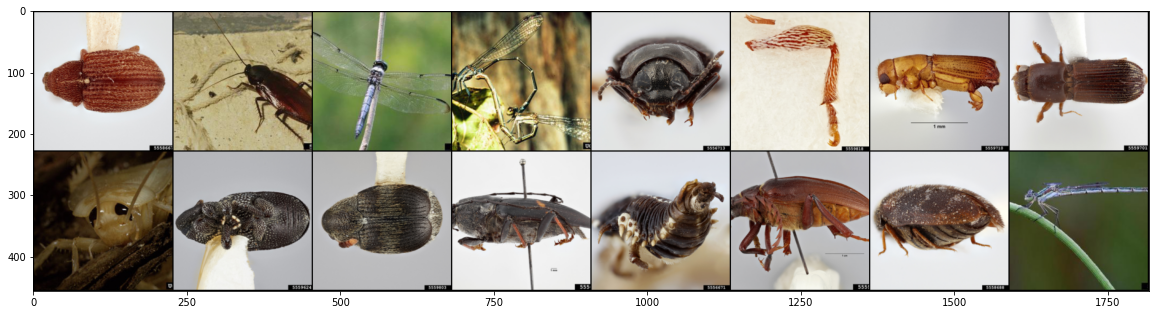

In [ ]:
# grab a batch of training data
images, labels = next(iter(dataloader))

# choose only 16 to plot
images = images[:16]

# visualize the data
grid_img = torchvision.utils.make_grid(images, 8)
plt.figure(figsize = (20,20))
plt.imshow(grid_img.permute(1, 2, 0))
plt.show();

### Loading train and test data 



In [36]:
# defining batch sizes

TRAIN_BATCH_SIZE = 64
VAL_BATCH_SIZE = 64

In [37]:
# transform the data and add data augmentation for train data

transform_train = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize(225),
    transforms.CenterCrop(224),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.Normalize(mean = [0.5754, 0.5431, 0.4762],
                         std = [0.2613, 0.2716, 0.2998])])


transform_val = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize(225),
    transforms.CenterCrop(224),
    transforms.Normalize(mean = [0.5754, 0.5431, 0.4762],
                         std = [0.2613, 0.2716, 0.2998])])

In [38]:
TRAIN_DATA_ROOT = "/content/drive/MyDrive/BIOS823/insects/train"
train_dataset = datasets.ImageFolder(TRAIN_DATA_ROOT, transform=transform_train)

VAL_DATA_ROOT = "/content/drive/MyDrive/BIOS823/insects/test"
val_dataset = datasets.ImageFolder(VAL_DATA_ROOT, transform=transform_val)

train_loader = torch.utils.data.DataLoader(train_dataset,
                                           batch_size=TRAIN_BATCH_SIZE,
                                           shuffle=True,
                                           num_workers=4)
test_loader = torch.utils.data.DataLoader(val_dataset,
                                          batch_size=VAL_BATCH_SIZE,
                                          shuffle=False,
                                          num_workers=4)


In [ ]:
# import torchvision. models as models
# resnet18 = models.resnet18(pretrained=True)
# model = resnet18.to(device) 

In [39]:
# define a two-layer CNN model
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        self.conv_layers = nn.Sequential(
            nn.Conv2d(3, 8, kernel_size=5),
            nn.BatchNorm2d(8),
            nn.MaxPool2d(2),
            nn.ReLU(),
            nn.Conv2d(8, 16, kernel_size=3),
            nn.BatchNorm2d(16),
            nn.MaxPool2d(2),
            nn.ReLU(),
        )
        self.fc_layers = nn.Sequential(
            nn.Linear(16*54*54, 120),
            nn.BatchNorm1d(120),
            nn.ReLU(),
            nn.Linear(120, 84),
            nn.BatchNorm1d(84),
            nn.ReLU(),
            nn.Linear(84, 3),
            nn.Softmax(dim=1)

        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(-1, 16*54*54)
        x = self.fc_layers(x)
        return x

In [40]:
# print out the exact model architecture
model = Net()
print("Model Architecture:")
print(model)

# pass in dummy examples to see if the model is built correctly


input_size = (128, 3, 224, 224)
sample = torch.rand(size = input_size)
out = model.forward(sample)
print(f"* Input tensor size: {input_size}, \n* Output tensor size: {out.size()}")
model = Net().to(device)

Model Architecture:
Net(
  (conv_layers): Sequential(
    (0): Conv2d(3, 8, kernel_size=(5, 5), stride=(1, 1))
    (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): ReLU()
    (4): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1))
    (5): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): ReLU()
  )
  (fc_layers): Sequential(
    (0): Linear(in_features=46656, out_features=120, bias=True)
    (1): BatchNorm1d(120, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=120, out_features=84, bias=True)
    (4): BatchNorm1d(84, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): Linear(in_features=84, out_features=3, bias=True)
    (7): Softmax(dim=1)
  )


In [41]:
num_epochs = 10
def train(model, device, train_loader, optimizer, epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output.log(), target)
        loss.backward()
        optimizer.step()
        if batch_idx % 5 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output.log(), target).item() # sum up batch loss
            pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
    100. * correct / len(test_loader.dataset)))

# put the model to GPU device
model = Net().to(device)

optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.5)

for epoch in range(1, num_epochs + 1):
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)

Train Epoch: 1 [0/1019 (0%)]	Loss: 1.103431
Train Epoch: 1 [320/1019 (31%)]	Loss: 0.515321
Train Epoch: 1 [640/1019 (62%)]	Loss: 0.489850
Train Epoch: 1 [885/1019 (94%)]	Loss: 0.412540

Test set: Average loss: 0.0138, Accuracy: 123/180 (68%)

Train Epoch: 2 [0/1019 (0%)]	Loss: 0.401856
Train Epoch: 2 [320/1019 (31%)]	Loss: 0.323526
Train Epoch: 2 [640/1019 (62%)]	Loss: 0.325633
Train Epoch: 2 [885/1019 (94%)]	Loss: 0.353190

Test set: Average loss: 0.0074, Accuracy: 157/180 (87%)

Train Epoch: 3 [0/1019 (0%)]	Loss: 0.380691
Train Epoch: 3 [320/1019 (31%)]	Loss: 0.263053
Train Epoch: 3 [640/1019 (62%)]	Loss: 0.295961
Train Epoch: 3 [885/1019 (94%)]	Loss: 0.287402

Test set: Average loss: 0.0055, Accuracy: 163/180 (91%)

Train Epoch: 4 [0/1019 (0%)]	Loss: 0.180127
Train Epoch: 4 [320/1019 (31%)]	Loss: 0.187405
Train Epoch: 4 [640/1019 (62%)]	Loss: 0.246126
Train Epoch: 4 [885/1019 (94%)]	Loss: 0.260187

Test set: Average loss: 0.0037, Accuracy: 167/180 (93%)

Train Epoch: 5 [0/1019 (0%)]

In [12]:
# since shuffle=True, this is a random sample of test data
batch = next(iter(dataloader))
images, _ = batch

background = images[:60]
test_images = images[4:9]

e = shap.DeepExplainer(model.cpu(), background)
shap_values = e.shap_values(test_images)

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/module.py:1025: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


In [13]:
shap_numpy = [np.swapaxes(np.swapaxes(s, 1, -1), 1, 2) for s in shap_values]
test_numpy = np.swapaxes(np.swapaxes(test_images.numpy(), 1, -1), 1, 2)

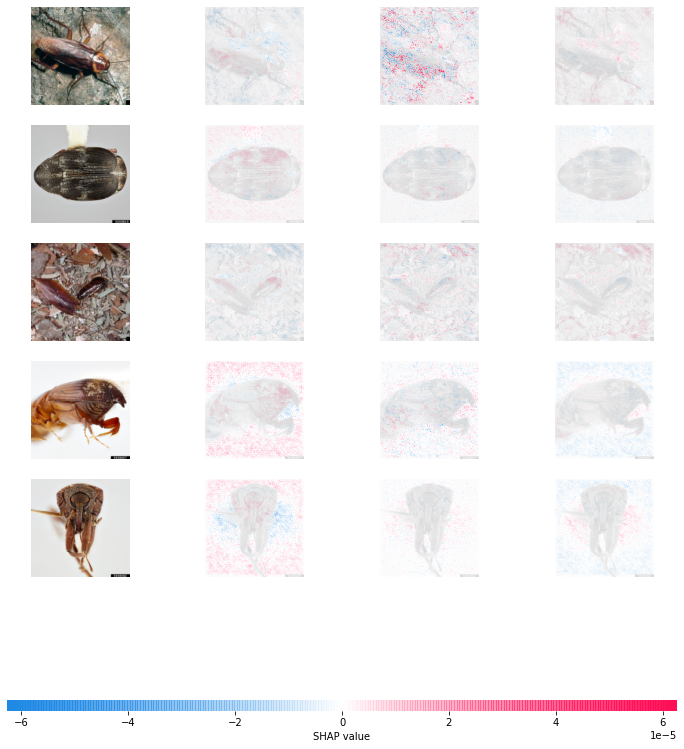

In [15]:
# plot the feature attributions
shap.image_plot(shap_numpy, test_numpy)